# 01) Importar librerias correspondientes

In [1]:
# importamos las librerías necesarias para trabajar.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

In [3]:
from sklearn.model_selection import GridSearchCV

# 02) Importar dataset de properati

In [98]:
df = pd.read_csv(r'C:\Users\Ezequiel Vannucchi\Desktop\UTN\Cs de datos\clase_04-master\clase_04-master\clusterai_2019_clase04_regresion_dataset_properati_caba.csv',parse_dates=True)
df.head()

,id,created_on,operation,property_type,neighbourhood,lat,lon,price,surface_total_in_m2,surface_covered_in_m2,floor,rooms,expenses
0,1649a3c35359d681abae4a63d9a8545054d2096b,2017-09-22,sell,house,Palermo Viejo,-34.588953,-58.429882,2000000.0,312.0,NaN,NaN,NaN,NaN
1,1ab035ccbe77702987c3f09850d12c634e612aa2,2017-09-01,sell,PH,Parque Chacabuco,-34.635866,-58.431048,131500.0,80.0,50.0,NaN,3.0,NaN
2,90fc7c61b6fbc6ef99368a21cd9ac0d30d54c697,2017-09-01,sell,apartment,Barracas,-34.644924,-58.371919,140000.0,125.0,85.0,NaN,NaN,NaN
3,c195e8f3a596ab49b95d699c07e1a04be503ba68,2017-09-01,sell,apartment,Recoleta,-34.596511,-58.385747,109000.0,45.0,45.0,2.0,2.0,3350.0
4,f891875ff44e6f99e30e101b3901d1e7510ef41b,2017-09-01,sell,apartment,Parque Patricios,-34.639173,-58.417069,94000.0,38.0,38.0,NaN,NaN,NaN


In [101]:
df.isnull().sum()


property_type            0
neighbourhood            0
price                    0
surface_total_in_m2      0
surface_covered_in_m2    0
rooms                    0
dtype: int64

In [100]:
df.drop(columns =['id','created_on','floor','expenses','operation','lat','lon'], inplace=True)
df.dropna(subset=['surface_covered_in_m2','surface_total_in_m2','rooms','price'], inplace=True)
df.shape

(16296, 6)

# 03) Revisar con que columnas trabajar para luego quitarle los NaNs (queremos predecir precio)

In [96]:
df.isnull().sum()

property_type              0
neighbourhood              0
lat                      601
lon                      601
price                      0
surface_total_in_m2        0
surface_covered_in_m2      0
rooms                      0
dtype: int64

In [87]:
df.dropna(subset= ['surface_total_in_m2','price','surface_covered_in_m2'], inplace=True)
df.head()

,property_type,neighbourhood,lat,lon,price,surface_total_in_m2,surface_covered_in_m2,rooms
1,PH,Parque Chacabuco,-34.635866,-58.431048,131500.0,80.0,50.0,3.0
3,apartment,Recoleta,-34.596511,-58.385747,109000.0,45.0,45.0,2.0
5,apartment,Flores,-34.639497,-58.531714,160000.0,76.0,76.0,3.0
6,apartment,Caballito,-34.628021,-58.460598,160000.0,76.0,76.0,3.0
7,apartment,Villa Crespo,-34.592540,-58.434245,240435.0,101.0,75.0,3.0


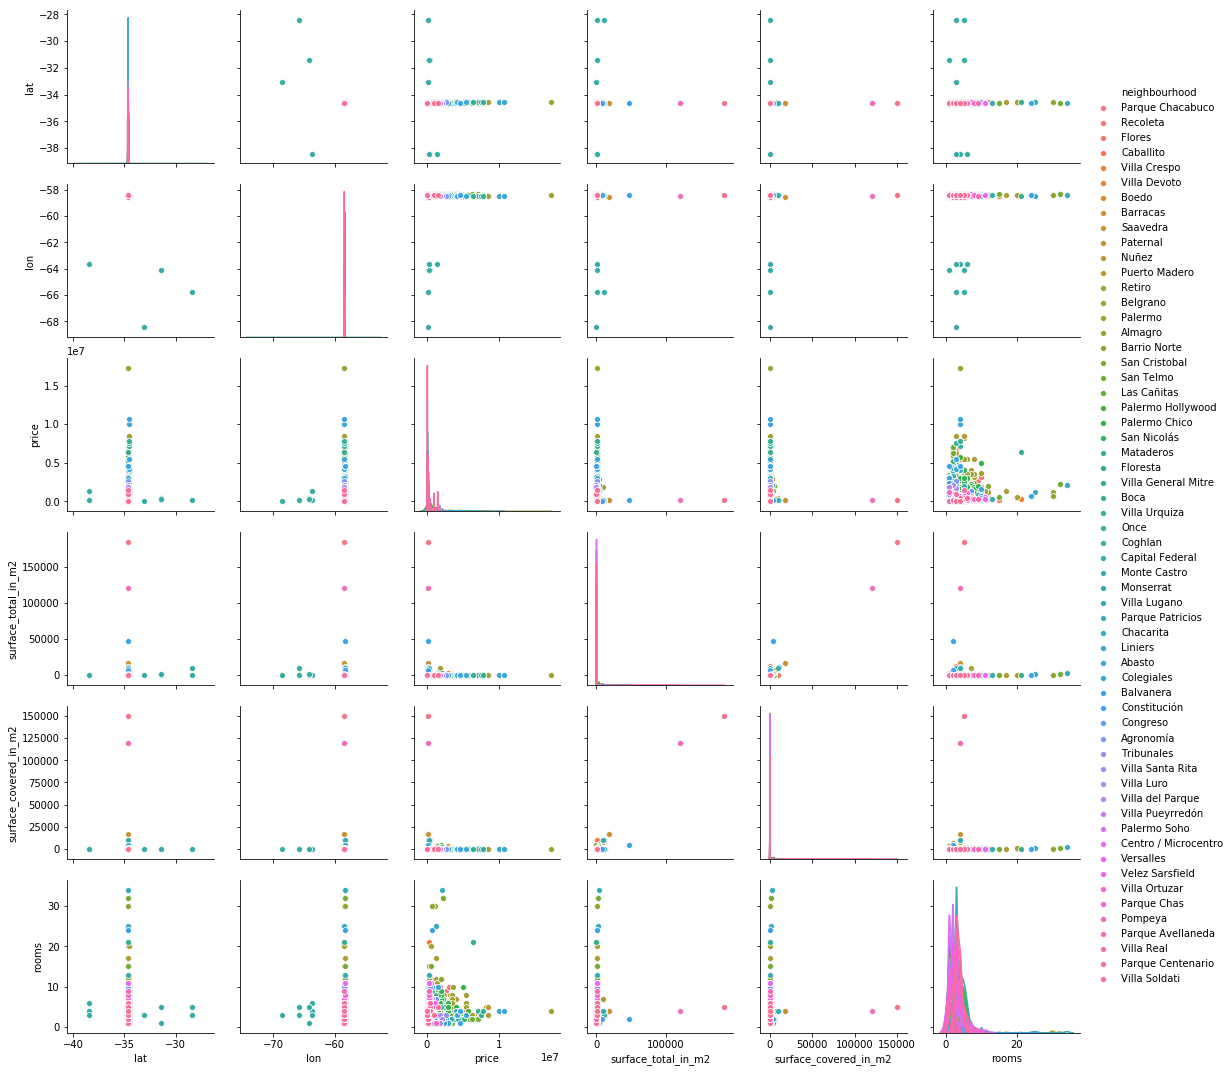

In [46]:
sns.pairplot(data=df,hue='neighbourhood')
plt.show()

In [70]:
df.describe()

,lat,lon,price,surface_total_in_m2,surface_covered_in_m2,rooms
count,15695.000000,15695.000000,1.569500e+04,15695.000000,15695.000000,15695.000000
mean,-34.597577,-58.437214,3.801331e+05,134.231921,113.864670,2.913539
std,0.106311,0.166970,6.282556e+05,1817.399556,1553.132279,1.771438
min,-38.416097,-68.466206,1.140000e+04,10.000000,2.000000,1.000000
25%,-34.616375,-58.460988,1.250000e+05,46.000000,41.000000,2.000000
50%,-34.598180,-58.433567,1.920000e+05,70.000000,63.000000,3.000000
75%,-34.579761,-58.400711,3.490000e+05,120.000000,103.000000,4.000000
max,-28.444290,-58.354381,1.725144e+07,184000.000000,150000.000000,34.000000


# 04) Quitar Outliers de las variables que consideren utilizando cuantiles

In [126]:
sftot_q97 = df.surface_total_in_m2.quantile(0.9)
print("el cuantil 0.97 de la feature 'surface_total_in_m2' es = " + str(sftot_q97))
sfcov_q97 = df.surface_covered_in_m2.quantile(0.9)
print("el cuantil 0.97 de la feature 'surface_covered_in_m2' es = " + str(sfcov_q97))
price_q97 = df.price.quantile(0.9)
print("el cuantil 0.97 de la feature 'price' es = " + str(price_q97))

el cuantil 0.97 de la feature 'surface_total_in_m2' es = 210.0
el cuantil 0.97 de la feature 'surface_covered_in_m2' es = 180.0
el cuantil 0.97 de la feature 'price' es = 750000.0


In [127]:
# aca filtro y conservo los valores que cumplen las dos condiciones al mismo tiempo
df_filt = df.loc[(df.price < price_q97)] | (df.surface_total_in_m2 < sftot_q97) | (df.surface_covered_in_m2 < sfcov_q97) ]
df_filt.shape

SyntaxError: invalid syntax (<ipython-input-127-2318c1741ae4>, line 2)

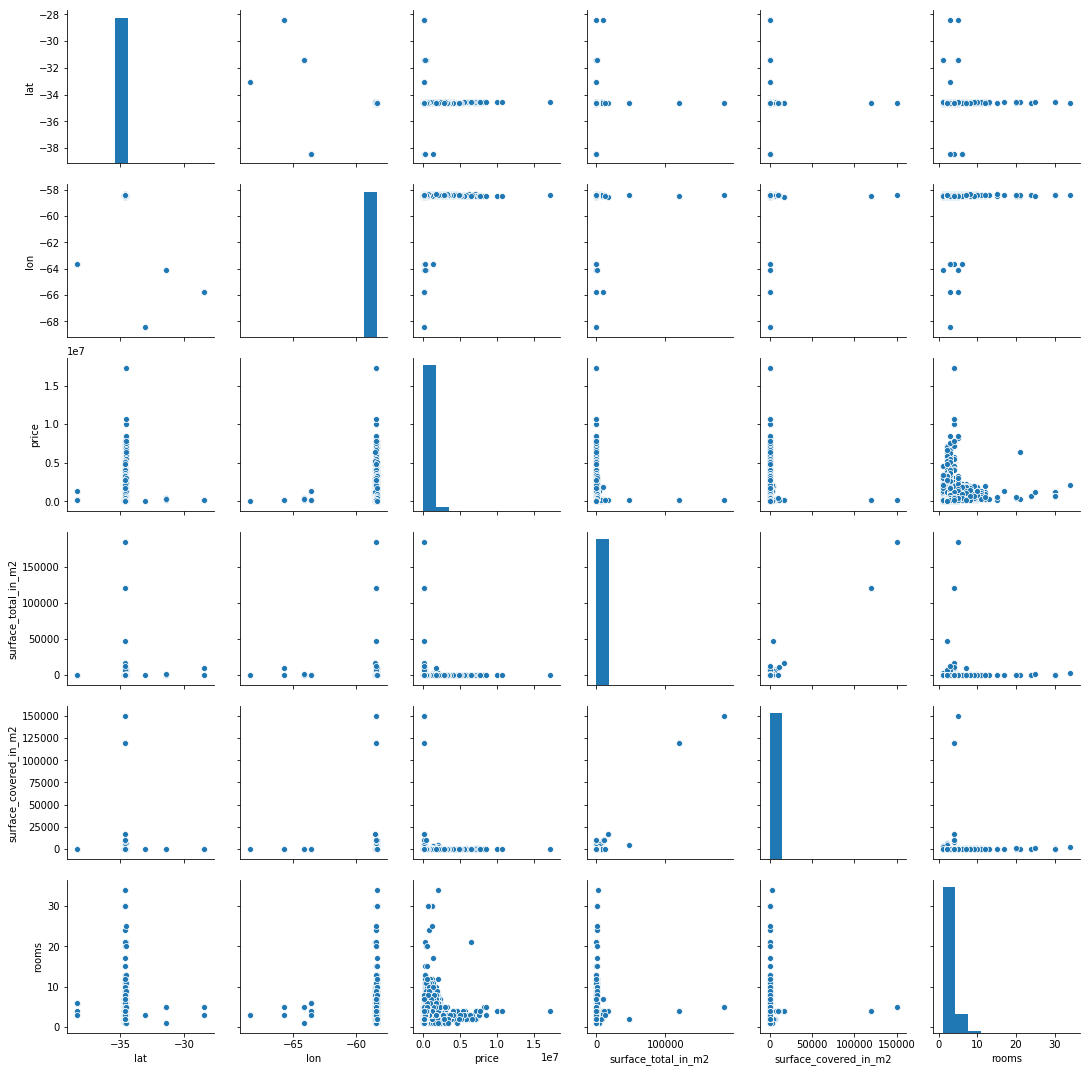

In [50]:
sns.pairplot(data=df_filt)
plt.show()

# 05) Realizar feature engineering si fuera necesario

In [128]:
neighbourhood_dummie = pd.get_dummies(df_filt.neighbourhood)
property_type_dummie = pd.get_dummies(df_filt.property_type)

In [129]:
df_filt2 = df_filt.join([neighbourhood_dummie, property_type_dummie])
df_filt2.drop(columns=['property_type', 'neighbourhood'], inplace=True)

In [130]:
df_filt2.head()

,price,surface_total_in_m2,surface_covered_in_m2,rooms,Abasto,Agronomía,Almagro,Balvanera,Barracas,Barrio Norte,...,Villa Pueyrredón,Villa Real,Villa Santa Rita,Villa Soldati,Villa Urquiza,Villa del Parque,PH,apartment,house,store
1,131500.0,80.0,50.0,3.0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,109000.0,45.0,45.0,2.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,160000.0,76.0,76.0,3.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6,160000.0,76.0,76.0,3.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
7,240435.0,101.0,75.0,3.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


# 06) Separar Y (price) & X (decidir que features utilizar para trabajar)
Recuerden realizar auto scaling sobre las variables en cuestion

In [131]:
y = np.array(df_filt2[["price"]])
x = df_filt2.drop(columns=['price'])

In [111]:
x.columns

Index(['surface_total_in_m2', 'surface_covered_in_m2', 'rooms', 'Abasto',
       'Agronomía', 'Almagro', 'Balvanera', 'Barracas', 'Barrio Norte',
       'Belgrano', 'Boca', 'Boedo', 'Caballito', 'Capital Federal',
       'Catalinas', 'Centro / Microcentro', 'Chacarita', 'Coghlan',
       'Colegiales', 'Congreso', 'Constitución', 'Flores', 'Floresta',
       'Las Cañitas', 'Liniers', 'Mataderos', 'Monserrat', 'Monte Castro',
       'Nuñez', 'Once', 'Palermo', 'Palermo Chico', 'Palermo Hollywood',
       'Palermo Soho', 'Palermo Viejo', 'Parque Avellaneda',
       'Parque Centenario', 'Parque Chacabuco', 'Parque Chas',
       'Parque Patricios', 'Paternal', 'Pompeya', 'Puerto Madero', 'Recoleta',
       'Retiro', 'Saavedra', 'San Cristobal', 'San Nicolás', 'San Telmo',
       'Tribunales', 'Velez Sarsfield', 'Versalles', 'Villa Crespo',
       'Villa Devoto', 'Villa General Mitre', 'Villa Lugano', 'Villa Luro',
       'Villa Ortuzar', 'Villa Pueyrredón', 'Villa Real', 'Villa Santa Rita',

In [132]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.10, random_state=42)

In [133]:
scaler = preprocessing.MinMaxS().fit(xtrain)
xtrain_scal = scaler.transform(xtrain)
xtest_scal = scaler.transform(xtest)

C:\Users\Ezequiel Vannucchi\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Ezequiel Vannucchi\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  
C:\Users\Ezequiel Vannucchi\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


# 07) Implementar un modelo de regresion para predecir el precio. De ser posible comparar performance de distintos modelos.

In [135]:
lr = LinearRegression()
lr.fit(xtrain_scal, ytrain)
ypred = lr.predict(xtrain_scal)
print('RMSEtrain = ' + str(np.sqrt(mean_squared_error(ytrain, ypred))))
ypred = lr.predict(xtest_scal)
print('RMSEtest = ' + str(np.sqrt(mean_squared_error(ytest, ypred))))
print('MSE = ' + str(mean_squared_error(ytest, ypred)))
print('MAE = ' + str(mean_absolute_error(ytest, ypred)))

RMSEtrain = 68553.88661929165
RMSEtest = 68096.18102974618
MSE = 4637089870.835963
MAE = 49767.33036237105


In [142]:
neigh = KNeighborsRegressor(weights = "distance")

parameters_knn = [{'n_neighbors': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,30,35,40,45,50]}]
regresor_neigh = GridSearchCV(neigh, parameters_knn, refit = True, cv=5, verbose=True)
neigh.fit(xtrain_scal, ytrain)
ypred = neigh.predict(xtrain_scal)
print('RMSE train = ' + str(np.sqrt(mean_squared_error(ytrain, ypred))))
ypred = neigh.predict(xtest_scal)
print('RMSE test = ' + str(np.sqrt(mean_squared_error(ytest, ypred))))
print('MSE = ' + str(mean_squared_error(ytest, ypred)))
print('MAE = ' + str(mean_absolute_error(ytest, ypred)))

RMSEtrain = 12266.595319022483
RMSE = 49398.094923643956
MSE = 2440171782.0853386
MAE = 31443.148551299586


In [ ]:
svr = SVR()
svr_param = [{'kernel':['linear','rbf','poly','sigmoid'], 'C': [0.1,1,10,100,1000], 'gamma':[0.01,0.1,1,10]}]
svr_cv = GridSearchCV(svr, svr_param, refit = True, cv=5, verbose=True)
svr_cv.fit(xtrain_scal, ytrain)
ypred = svr_cv.predict(xtrain_scal)
print('RMSE train = ' + str(np.sqrt(mean_squared_error(ytrain, ypred))))
ypred = svr_cv.predict(xtest_scal)
print('RMSE test = ' + str(np.sqrt(mean_squared_error(ytest, ypred))))
print('MSE = ' + str(mean_squared_error(ytest, ypred)))
print('MAE = ' + str(mean_absolute_error(ytest, ypred)))

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Ezequiel Vannucchi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Ezequiel Vannucchi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Ezequiel Vannucchi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Ezequiel Vannucchi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:7

C:\Users\Ezequiel Vannucchi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Ezequiel Vannucchi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Ezequiel Vannucchi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Ezequiel Vannucchi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expec

C:\Users\Ezequiel Vannucchi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Ezequiel Vannucchi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Ezequiel Vannucchi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Ezequiel Vannucchi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expec

C:\Users\Ezequiel Vannucchi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Ezequiel Vannucchi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Ezequiel Vannucchi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Ezequiel Vannucchi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expec

C:\Users\Ezequiel Vannucchi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Ezequiel Vannucchi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Ezequiel Vannucchi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Ezequiel Vannucchi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expec

C:\Users\Ezequiel Vannucchi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
